#Install and Import Library

In [1379]:
!pip install yfinance

In [1380]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import keras
from datetime import date
import joblib

In [1381]:
import unittest

#Get Data

In [1382]:
# DATA_PATH = "data_saham.csv"
# data = yf.download("BTC-USD", start="2023-11-01", end="2024-11-10", interval = "1d")
# print(data)
# data.to_csv(DATA_PATH)

DATA_PATH = "data_saham.csv"
date_now = date.today().isoformat()
data = yf.download("ASII.JK", start="2000-10-17", end=date_now, interval = "1wk")
print(data)
data.to_csv(DATA_PATH)

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                         ASII.JK      ASII.JK      ASII.JK      ASII.JK   
Date                                                                            
2000-10-16 00:00:00+00:00    76.228111   177.745636   195.133789   175.813614   
2000-10-23 00:00:00+00:00    74.570992   173.881592   181.609665   171.949570   
2000-10-30 00:00:00+00:00    70.428162   164.221512   173.881592   164.221512   
2000-11-06 00:00:00+00:00    72.085274   168.085541   173.881592   164.221512   
2000-11-13 00:00:00+00:00    67.942444   158.425446   170.017563   158.425446   
...                                ...          ...          ...          ...   
2024-10-28 00:00:00+00:00  5075.000000  5075.000000  5300.000000  5050.000000   
2024-11-04 00:00:00+00:00  4960.000000  4960.000000  5200.000000  4950.000000   
2024-11-11 00:00:00+00:00  4940.000000  4940.000000  5025.000000  4850.000000   
2024-11-18 00:00:00+00:00  4

In [1383]:
def parse_data_from_file(filename):
  # Load the file, skipping the first three rows to remove unnecessary headers
  data = pd.read_csv('data_saham.csv', skiprows=[1,2])

  # Rename price column to date
  data.rename(columns={'Price': 'Date'}, inplace=True)

  # Convert the 'Date' column to datetime format
  data['Date'] = pd.to_datetime(data['Date'])

  # Set 'Date' as the index
  data.set_index('Date', inplace=True)

  # Select only the 'Adj Close' column for forecasting
  data = data[['Adj Close']]

  data.head()

  dates = data.index.tolist()
  adj_closes = data['Adj Close'].tolist()

  return np.array(dates), np.array(adj_closes)

In [1384]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

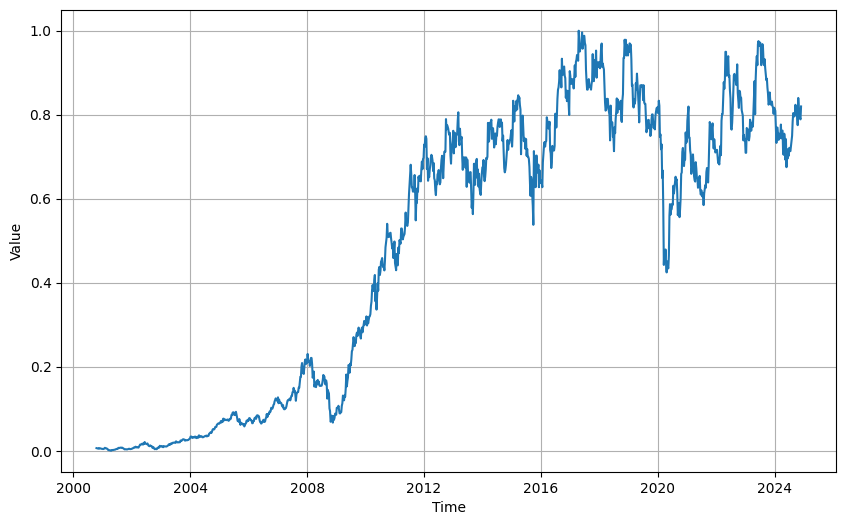

In [1385]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the series data
SERIES = scaler.fit_transform(SERIES.reshape(-1, 1)).flatten()

joblib.dump(scaler, 'scaler.pkl')

# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

#Global Variable

In [1386]:
# Save all global variables
SPLIT_TRAIN = int(len(SERIES) * 0.8)
SPLIT_VALID = int(len(SERIES) * 0.9)
WINDOW_SIZE = 60
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

#Train Data

In [1387]:
#Split data train and validation
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TRAIN]
    series_train = series[:SPLIT_TRAIN]

    time_valid = time[SPLIT_TRAIN:SPLIT_VALID]
    series_valid = series[SPLIT_TRAIN:SPLIT_VALID]

    time_test = time[SPLIT_VALID:]
    series_test = series[SPLIT_VALID:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

In [1388]:
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_split(TIME, SERIES)

In [1389]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [1390]:
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)
valid_dataset = windowed_dataset(series_valid, window_size=WINDOW_SIZE)
test_dataset = windowed_dataset(series_test, window_size=WINDOW_SIZE)

#Defining the model architecture


In [1391]:
# def create_uncompiled_model():
#     """Define uncompiled model

#     Returns:
#         tf.keras.Model: uncompiled model
#     """

#     model = tf.keras.models.Sequential([
#         tf.keras.Input(shape=(None, 1)),
#         tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='causal'),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),
#         tf.keras.layers.Dense(1),
#         tf.keras.layers.Lambda(lambda x: x * 200)
#     ])

#     return model

In [1392]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(None, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200)
    ])

    return model

In [1393]:
uncompiled_model = create_uncompiled_model()

In [1394]:
example_batch = train_dataset.take(1)

In [1395]:
try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")


Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (16, 1)


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [1396]:
uncompiled_model.summary()

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_63 (Conv1D)                   │ (None, None, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_126 (Bidirectional)    │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_127 (Bidirectional)    │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_63 (Lambda)                   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,249 (645.50 KB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 0 (0.00 B)

#Adjust Learning Rate

In [1397]:
# def adjust_learning_rate(dataset):
#     """Fit model using different learning rates."""
#     model = create_uncompiled_model()

#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

#     # Compile the model
#     model.compile(
#         loss='mse',
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#         metrics=["mse"]
#     )


#     # Fit the model
#     history = model.fit(dataset, validation_data = valid_dataset, epochs=30, callbacks=[lr_schedule])
#     return history

In [1398]:
# lr_history = adjust_learning_rate(train_dataset)

# plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

#Create Model

In [1399]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss='huber',
                  optimizer='adam',
                  metrics=["mae", "mse"])

    return model

In [1400]:
# Instantiate and train the model with early stopping
model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_dataset, validation_data = valid_dataset, epochs=100, callbacks=[early_stopping])

# Output the model summary and training history (loss per epoch)
model.summary(), history.history['loss'][:10]

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 4.5299 - mae: 4.9625 - mse: 84.3127 - val_loss: 0.2758 - val_mae: 0.7281 - val_mse: 0.5515
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0529 - mae: 0.2172 - mse: 0.1059 - val_loss: 0.0125 - val_mae: 0.1283 - val_mse: 0.0250
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - mae: 0.0541 - mse: 0.0052 - val_loss: 0.0050 - val_mae: 0.0826 - val_mse: 0.0101
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - mae: 0.0530 - mse: 0.0055 - val_loss: 0.0152 - val_mae: 0.1556 - val_mse: 0.0303
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - mae: 0.0718 - mse: 0.0097 - val_loss: 0.0210 - val_mae: 0.1953 - val_mse: 0.0421
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0243 - mae: 0.1570 - mse: 0.0486 - val_loss: 0.0784 - val_mae: 0.3891 - val_mse: 0.1568
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0380 - mae: 0.2053 - mse: 0.0761 - v

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)                   │ (None, None, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_128 (Bidirectional)    │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_129 (Bidirectional)    │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_64 (Lambda)                   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,749 (1.89 MB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 330,500 (1.26 MB)

(None,
 [1.7008696794509888,
  0.02183513715863228,
  0.0028309375047683716,
  0.00225047511048615,
  0.0030560169834643602,
  0.03784758970141411,
  0.029173223301768303,
  0.04529303312301636,
  0.0033576085697859526,
  0.002594791119918227])

In [1401]:
# Plot the training loss for each epoch
loss = history.history['loss']
# loss = best_validation_loss
epochs = range(len(loss))

In [1402]:
# Evaluasi akhir model pada test set
train_loss = model.evaluate(train_dataset)
print("Train Loss:", train_loss)

# Evaluasi akhir model pada test set
valid_loss = model.evaluate(valid_dataset)
print("Valid Loss:", valid_loss)

# Evaluasi akhir model pada test set
test_loss = model.evaluate(test_dataset)
print("Test Loss:", test_loss)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9124e-04 - mae: 0.0187 - mse: 5.8247e-04
Train Loss: [0.00028906832449138165, 0.01856289803981781, 0.0005781366489827633]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3955e-04 - mae: 0.0247 - mse: 8.7910e-04
Valid Loss: [0.0003916726273018867, 0.022750496864318848, 0.0007833452546037734]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5797e-04 - mae: 0.0187 - mse: 5.1594e-04
Test Loss: [0.0002753232547547668, 0.01892893575131893, 0.0005506465095095336]


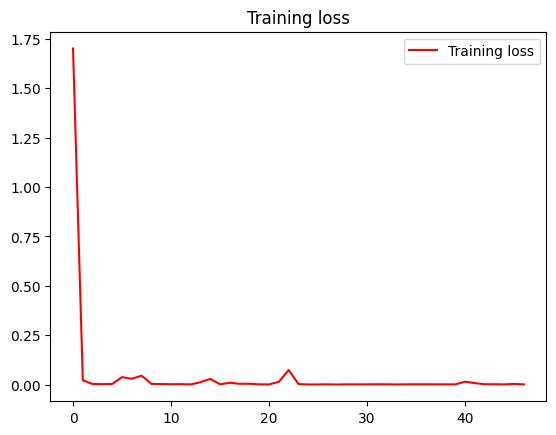

In [1403]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

#Evaluate Forecast & Model Forecast

In [1404]:
"""## Evaluating the forecast"""
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [1405]:
"""## Faster Model Forecasts"""
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [1406]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
# rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()
# rnn_forecast = model_forecast(model, SCALED_FEATURE_DATA[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

In [1407]:
# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, series_valid)
# plot_series(time_valid, rnn_forecast)

#TESTING AND PLOTTING USING BOTH VALID AND TEST SET (IF AVAILABLE)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


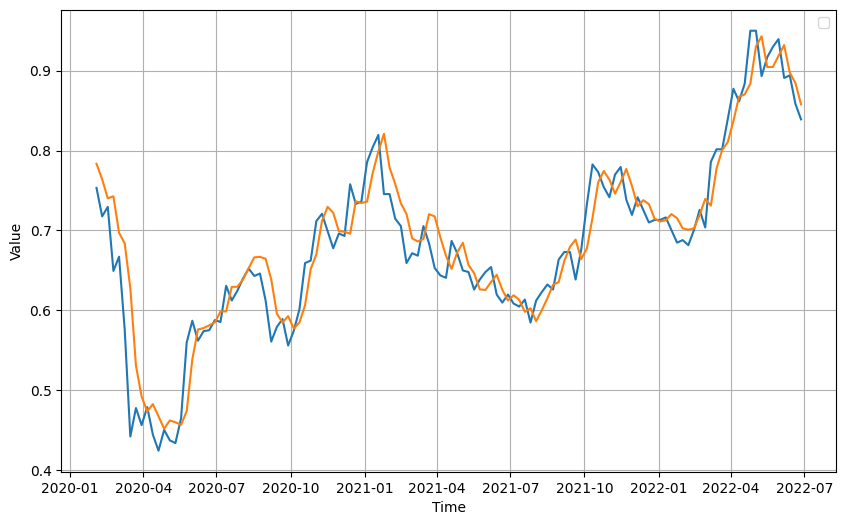

In [1408]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


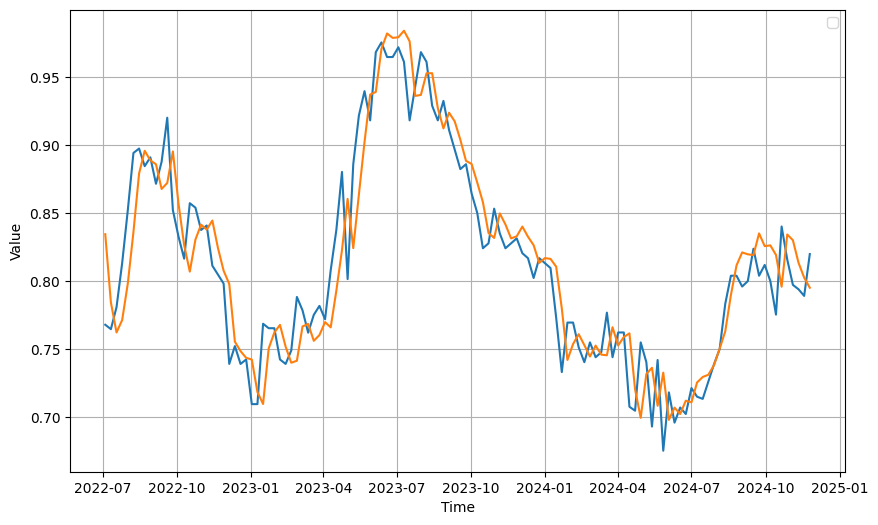

In [1409]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


252
252


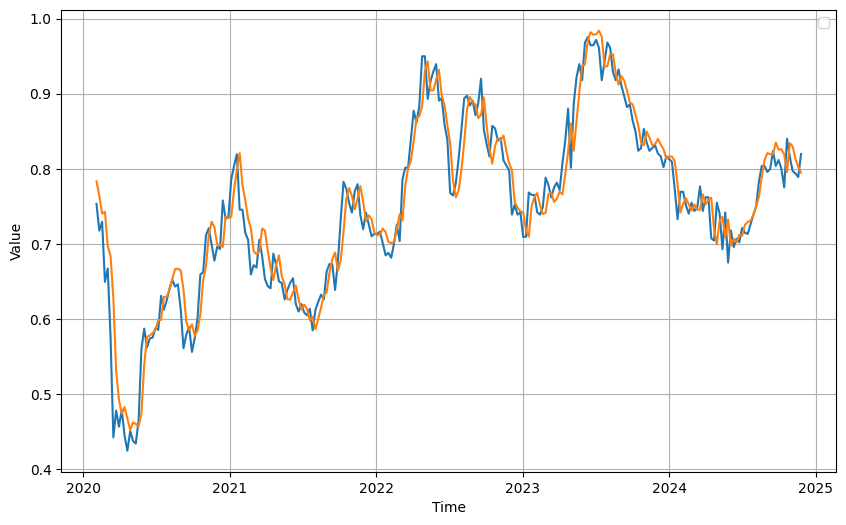

In [1410]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()


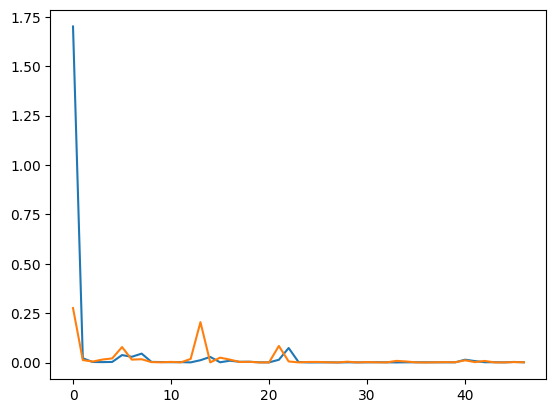

In [1411]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


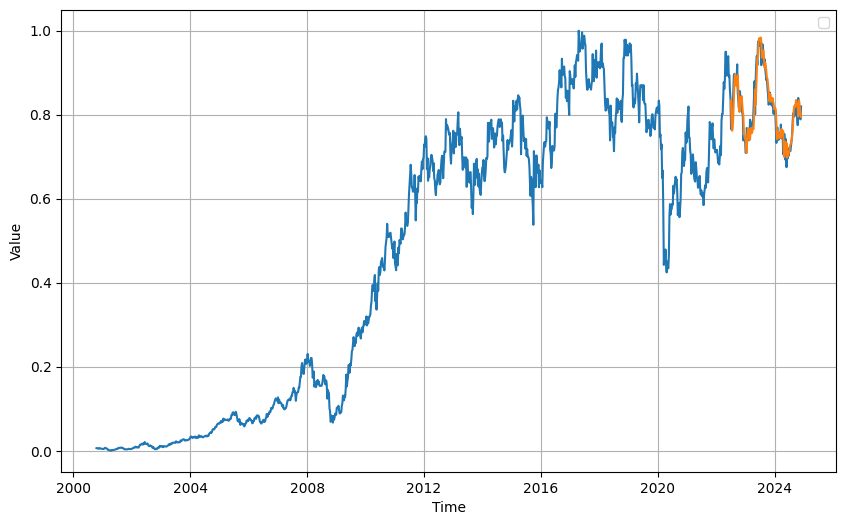

In [1412]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

time_full = np.concatenate([time_train, time_valid, time_test])
series_full = np.concatenate([series_train, series_valid, series_test])

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(time_full, series_full)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

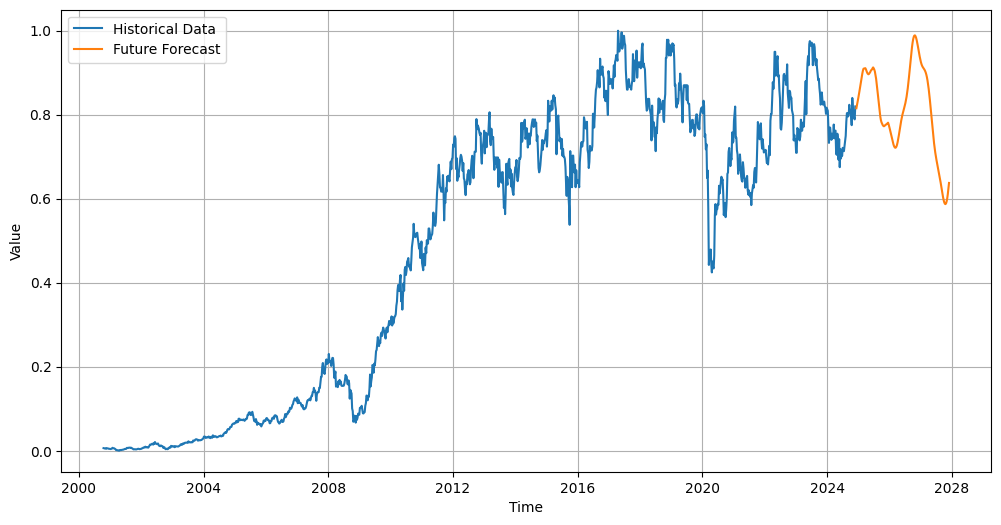

In [1413]:
# Constants
WEEKS_IN_3_YEARS = 3 * 52  # 3 tahun ke depan, setiap tahun 52 minggu
last_time = pd.Timestamp(time_test[-1])  # Pastikan time_test adalah seri waktu yang valid

# Generate future timestamps dengan frekuensi mingguan
future_time = pd.date_range(start=last_time, periods=WEEKS_IN_3_YEARS + 1, freq='W')[1:]  # Hilangkan timestamp awal

# Forecast future values
future_forecast = []
last_window = SERIES[-WINDOW_SIZE:]  # Ambil window terakhir dari dataset

for _ in range(WEEKS_IN_3_YEARS):
    prediction = model.predict(last_window[np.newaxis, :])  # Prediksi satu langkah ke depan
    future_forecast.append(prediction.squeeze())
    # Perbarui window dengan memasukkan prediksi baru
    last_window = np.roll(last_window, -1)
    last_window[-1] = prediction.squeeze()

# Convert future_forecast to numpy array
future_forecast = np.array(future_forecast)

# Plot the test and future forecast
plt.figure(figsize=(12, 6))
plot_series(time_full, series_full)  # Plot data historis
plot_series(future_time, future_forecast)  # Plot prediksi 3 tahun ke depan
plt.legend(['Historical Data', 'Future Forecast'])
plt.show()

#MAE & MSE EVALUATION

In [1414]:
mse, mae = compute_metrics(series_test    , rnn_forecast_test)

print(f"mse: {mse:.5f}, mae: {mae:.5f} for forecast")

mse: 0.00079, mae: 0.02223 for forecast


#Forecast The Future Series

In [1415]:
# import numpy as np
# import matplotlib.pyplot as plt

# def extended_forecast(model, series, window_size, forecast_steps):
#     """
#     Generates a forecast using your trained model up to a specified number of future steps.
#     """
#     # Initialize forecast results with the original series to begin prediction
#     forecast = list(series[-window_size:])  # Start from the last known window

#     for _ in range(forecast_steps):
#         # Convert forecast list to tensor
#         input_series = np.array(forecast[-window_size:]).reshape(1, -1)  # Shape (1, window_size)

#         # Predict the next step
#         next_step = model.predict(input_series)[0][0]  # Get the predicted value

#         # Append the next step to the forecast
#         forecast.append(next_step)

#     # Return only the future forecasted steps
#     return np.array(forecast[-forecast_steps:])

# def plot_extended_forecast(model, series, window_size, forecast_steps, start_year):
#     """
#     Generates a forecast using your trained model up to a specified number of future steps
#     and plots it along with the original series.
#     """
#     # Generate extended forecast
#     forecast = extended_forecast(model, series, window_size, forecast_steps)

#     # Define years for plotting
#     historical_years = np.arange(start_year, start_year + len(series))
#     future_years = np.arange(start_year + len(series), start_year + len(series) + forecast_steps)

#     # Plot historical data and forecast
#     plt.figure(figsize=(12, 6))
#     plt.plot(historical_years, series, label="Historical Data", color="blue")
#     plt.plot(future_years, forecast, label="Forecast", color="red", linestyle="--")

#     # Adjust x-axis ticks for years
#     tick_years = np.concatenate((historical_years, future_years))
#     plt.xticks(tick_years, [str(year) for year in tick_years], rotation=45)

#     # Add labels and legend
#     plt.xlabel("Year")
#     plt.ylabel("Value")
#     plt.title("Historical Data and Extended Forecast")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Contoh pemanggilan fungsi plot dengan input yang disesuaikan
# start_year = 2024  # Tahun pertama data historis
# forecast_steps = 3*52  # Jumlah tahun yang ingin diprediksi (2025-2030)

# plot_extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps, start_year)

In [1416]:
predicted_values = extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps=6)
print(predicted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.8155064  0.8226613  0.83082664 0.8382804  0.846159   0.8548419 ]


#Save and Load Model

In [1417]:
model.save('model_saham.h5')
keras.saving.save_model(model, 'my_model.keras')

In [1418]:
new_model = tf.keras.models.load_model('my_model.keras', safe_mode=False)

# # Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
# rnn_forecast = model_forecast(new_model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()
# # rnn_forecast = model_forecast(model, SCALED_FEATURE_DATA[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, series_valid)
# plot_series(time_valid, rnn_forecast)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


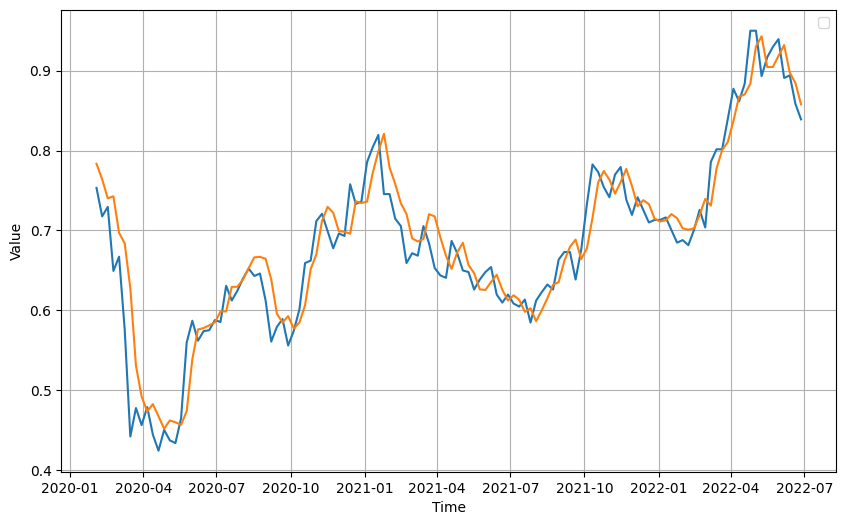

In [1419]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(new_model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


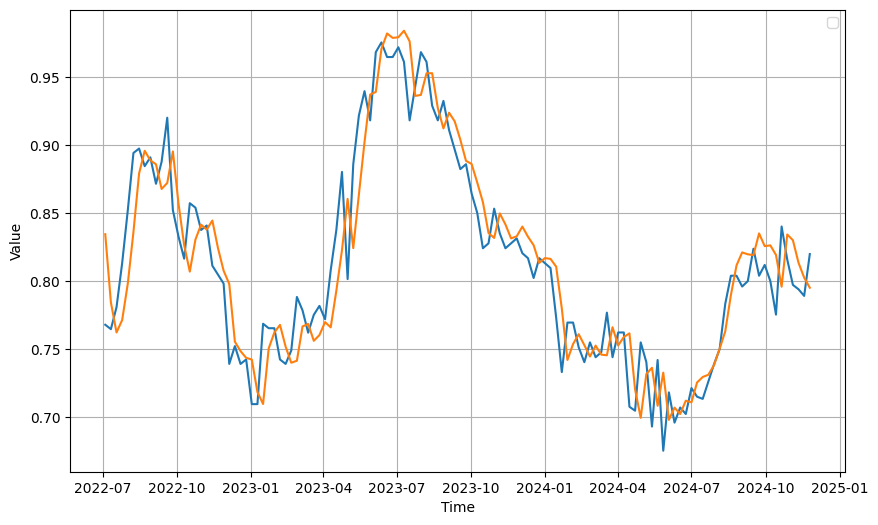

In [1420]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


252
252


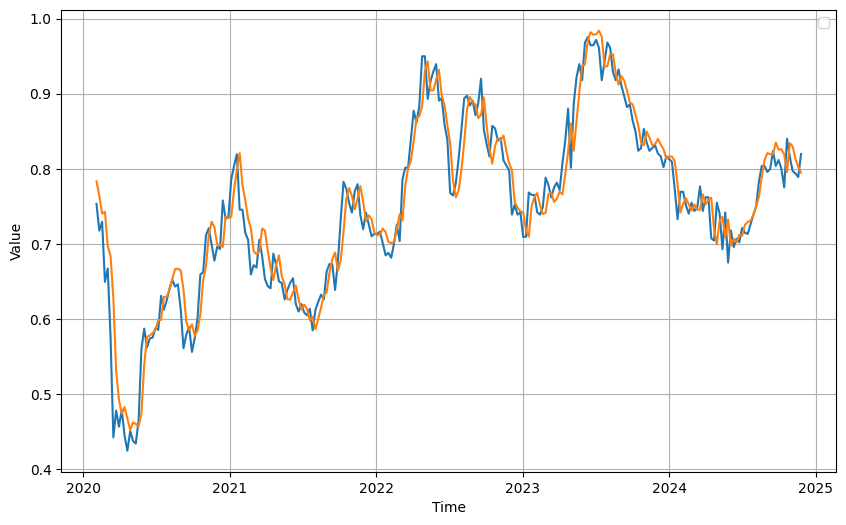

In [1421]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()

In [1422]:
config = model.get_config()
print(config)

{'name': 'sequential_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, None, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_64'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': (3,), 'strides': (1,), 'padding': 'causal', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_na